In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML1M'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['index', 'age', 'flag_train', 'gender', 'genre', 'itemId', 'maxSeqNum',
       'month', 'month_acq', 'occupation',
       ...
       'f_tag_to', 'f_tag_trek', 'f_tag_wars', 'f_tag_weapon', 'f_tag_who',
       'f_tag_with', 'f_tag_world', 'f_tag_you', 'user_idx', 'item_idx'],
      dtype='object', length=392)

In [5]:
denseCols=dftrain.columns[dftrain.columns.str.startswith('f_t')].tolist()

In [6]:
denseCols

['f_title_1939',
 'f_title_1940',
 'f_title_1941',
 'f_title_1942',
 'f_title_1944',
 'f_title_1946',
 'f_title_1950',
 'f_title_1951',
 'f_title_1953',
 'f_title_1954',
 'f_title_1955',
 'f_title_1956',
 'f_title_1957',
 'f_title_1958',
 'f_title_1959',
 'f_title_1960',
 'f_title_1961',
 'f_title_1962',
 'f_title_1963',
 'f_title_1964',
 'f_title_1965',
 'f_title_1966',
 'f_title_1967',
 'f_title_1968',
 'f_title_1969',
 'f_title_1970',
 'f_title_1971',
 'f_title_1972',
 'f_title_1973',
 'f_title_1974',
 'f_title_1975',
 'f_title_1976',
 'f_title_1977',
 'f_title_1978',
 'f_title_1979',
 'f_title_1980',
 'f_title_1981',
 'f_title_1982',
 'f_title_1983',
 'f_title_1984',
 'f_title_1985',
 'f_title_1986',
 'f_title_1987',
 'f_title_1988',
 'f_title_1989',
 'f_title_1990',
 'f_title_1991',
 'f_title_1992',
 'f_title_1993',
 'f_title_1994',
 'f_title_1995',
 'f_title_1996',
 'f_title_1997',
 'f_title_1998',
 'f_title_1999',
 'f_title_2000',
 'f_title_about',
 'f_title_adventures',
 'f_tit

In [7]:
genre_to_idx={j:i+1 for i,j in enumerate(dftrain['genre'].unique())}
idx_to_genre={i+1:j for i,j in enumerate(dftrain['genre'].unique())}
dftrain['genre_idx']=[genre_to_idx.get(i) for i in dftrain['genre']]
dfvalid['genre_idx']=[genre_to_idx.get(i) for i in dfvalid['genre']]

In [8]:
occupation_to_idx={j:i+1 for i,j in enumerate(dftrain['occupation'].unique())}
idx_to_occupation={i+1:j for i,j in enumerate(dftrain['occupation'].unique())}
dftrain['occupation_idx']=[occupation_to_idx.get(i) for i in dftrain['occupation']]
dfvalid['occupation_idx']=[occupation_to_idx.get(i) for i in dfvalid['occupation']]

In [9]:
age_to_idx={j:i+1 for i,j in enumerate(dftrain['age'].unique())}
idx_to_age={i+1:j for i,j in enumerate(dftrain['age'].unique())}
dftrain['age_idx']=[age_to_idx.get(i) for i in dftrain['age']]
dfvalid['age_idx']=[age_to_idx.get(i) for i in dfvalid['age']]

In [10]:
gender_to_idx={j:i+1 for i,j in enumerate(dftrain['gender'].unique())}
idx_to_gender={i+1:j for i,j in enumerate(dftrain['gender'].unique())}
dftrain['gender_idx']=[gender_to_idx.get(i) for i in dftrain['gender']]
dfvalid['gender_idx']=[gender_to_idx.get(i) for i in dfvalid['gender']]

In [11]:
catCols=['genre_idx','occupation_idx','age_idx','gender_idx']

### Dataset and DataLoader

In [12]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols,catCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        self.catCols=catCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [13]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+denseCols+catCols],dftrain['rating'],denseCols,catCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+denseCols+catCols],dfvalid['rating'],denseCols,catCols)

In [14]:
dftrain.shape

(895738, 396)

In [15]:
bs=128

In [16]:
dltrain=DataLoader(dstrain,bs,True)

In [17]:
dlvalid=DataLoader(dsvalid,bs,False)

In [18]:
dftrain['genre'].nunique()

301

In [19]:
[(col, dftrain[col].nunique()) for col in catCols]

[('genre_idx', 301), ('occupation_idx', 21), ('age_idx', 7), ('gender_idx', 2)]

In [20]:
{col: min(50,dftrain[col].nunique()//100) for col in catCols}

{'genre_idx': 3, 'occupation_idx': 0, 'age_idx': 0, 'gender_idx': 0}

In [21]:
emb_szs=[(dftrain[col].nunique(),min(50,dftrain[col].nunique()//2)) for col in catCols]

In [22]:
emb_szs

[(301, 50), (21, 10), (7, 3), (2, 1)]

In [28]:
len(denseCols)

350

## Model Architecture

In [107]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=50
n_emb_item=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.1
    # embedding, dense, cat, pre-final-1,pre-final-2
hidden=[25,25,25,25,10]
dropouts=[0.2,0.5,0.5,0.2,0.2]

In [108]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [109]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs_50','rb'))
#pretrain_wts=None

In [110]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 catCols, emb_szs,dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse",\
                lambda_l2=0.1,lambda_l1=0.1,use_l2=False,use_l1=False):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.catCols,self.emb_szs=catCols,emb_szs
        self.lambda_l2,self.lambda_l1=lambda_l2,lambda_l1
        self.len_cat_cols=len(self.catCols)
        self.n_cat_emb=sum([x[1] for x in emb_szs])
        self.use_l2,self.use_l1=use_l2,use_l1
        
        
        self.create_architecture()
        self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        self.embs_cat=nn.ModuleList([nn.Embedding(x+1,y) for x,y in self.emb_szs])
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.LeakyReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
       
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.LeakyReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin_cat= nn.Sequential (nn.Linear(self.n_cat_emb,self.hidden[2]),
                                nn.ReLU(),
                                nn.Dropout(p=dropouts[2]))
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+1+self.hidden[2],self.hidden[3]),
                    nn.LeakyReLU(),
                    nn.Dropout(p=dropouts[3]))
        self.lin4= nn.Sequential (nn.Linear(self.hidden[3],self.hidden[4]),
                    nn.LeakyReLU(),
                    nn.Dropout(p=dropouts[4]))
        self.lin5=nn.Linear(self.hidden[4],1)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)
        nn.init.kaiming_normal_(self.lin2[0].weight.data)
        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
    def add_l2_reg (self,lin_parameters):
        lin = torch.cat([x.view(-1) for x in lin_parameters])
        l2=self.lambda_l2 * torch.norm(lin,2)
        return l2
        
    def add_l1_reg (self,lin_parameters):
        lin = torch.cat([x.view(-1) for x in lin_parameters])
        l1=self.lambda_l1 * torch.norm(lin,1)
        return l1    
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out1=self.lin1(embed)
        bias=torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased=self.lin_bias(bias)
           
        
        denses=Xb[:,2:(2+self.len_dense_cols)]
        out2=self.lin2(denses)
                  
        cats=Xb[:,(2+self.len_dense_cols):].long()
        embed_cat=[self.emb_dropout(self.embs_cat[i](cats[:,i]) ) for i in range(len(self.emb_szs))]
        embedded_cat = torch.cat([x for x in embed_cat],1)
        out_cat=self.lin_cat(embedded_cat)
        
        out3=torch.cat([out1,out2,biased,out_cat],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        out6=self.lin5(out5)
        
        out=self.sigmoid(out6)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=torch.clamp(out,self.min_rating,self.max_rating)
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        
        loss=self.criterion(preds,Yb)
        if self.use_l2:
            loss = loss +  self.add_l2_reg(self.lin_emb.parameters()) + \
                    self.add_l2_reg(self.lin_bias.parameters()) + \
                    self.add_l2_reg(self.lin_cat.parameters()) + \
                    self.add_l2_reg(self.lin_dense.parameters()) + \
                    self.add_l2_reg (self.lin3.parameters()) + \
                    self.add_l2_reg (self.lin4.parameters())+ self.add_l2_reg (self.lin5.parameters())
        
        
        
        
        return preds,loss

In [65]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse",lambda_l2=0.1)

In [66]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (embs_cat): ModuleList(
    (0): Embedding(302, 50)
    (1): Embedding(22, 10)
    (2): Embedding(8, 3)
    (3): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=350, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (lin_cat): Sequential(
    (0): Linear(in_features=64, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (lin3): Sequential(
    (0): Linear(in_features=76, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace

In [67]:
for Xb, Yb in dltrain:
    break

In [68]:
Xb.shape, Yb.shape

(torch.Size([128, 356]), torch.Size([128, 1]))

In [69]:
Xb.dtype

torch.float32

In [70]:
cfobj.forward(Xb,Yb)

(tensor([[3.7259],
         [3.3878],
         [3.2985],
         [3.4857],
         [3.3912],
         [3.5981],
         [3.2287],
         [3.3764],
         [3.4565],
         [3.4027],
         [3.3328],
         [3.4322],
         [3.3488],
         [3.3426],
         [3.2852],
         [3.4493],
         [3.3224],
         [3.4253],
         [3.2826],
         [3.3855],
         [3.5188],
         [3.2881],
         [3.3139],
         [3.3838],
         [3.3193],
         [3.2956],
         [3.3372],
         [3.2853],
         [3.7249],
         [3.5148],
         [3.3033],
         [3.3576],
         [3.2445],
         [3.3961],
         [3.4270],
         [3.3722],
         [3.4580],
         [3.5715],
         [3.3586],
         [3.2019],
         [3.4825],
         [3.3276],
         [3.3077],
         [3.3133],
         [3.3347],
         [3.4808],
         [3.4574],
         [3.4037],
         [3.3571],
         [3.3404],
         [3.2922],
         [3.3430],
         [3.

## Learner

In [71]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None,ignore=0):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs[ignore:],y=pd.Series(self.losses[ignore:]).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [72]:
device='cuda:1'

In [73]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")

In [74]:
cfobj.use_l2,cfobj.use_l1

(False, False)

In [75]:
cfobj=cfobj.to(device)

In [76]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (embs_cat): ModuleList(
    (0): Embedding(302, 50)
    (1): Embedding(22, 10)
    (2): Embedding(8, 3)
    (3): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=350, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (lin_cat): Sequential(
    (0): Linear(in_features=64, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (lin3): Sequential(
    (0): Linear(in_features=76, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace

In [77]:
wd=3e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,14000,0.25,cycle_mult=0)

In [78]:
dltrain.batch_size, len(dltrain)

(128, 6998)

In [79]:
learner.lr_find(1e-5,1e-1,dltrain,len(dltrain))

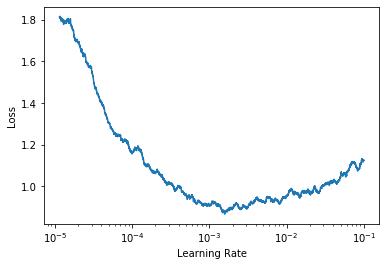

In [80]:
learner.plot_lrs(100)

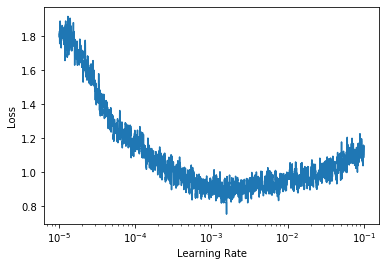

In [81]:
learner.plot_lrs(10)

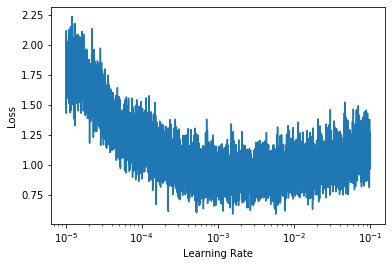

In [82]:
learner.plot_lrs(1)

In [111]:
del cfobj
torch.cuda.empty_cache()

In [112]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs_50','rb'))
#pretrain_wts=None

In [113]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,\
         dropout_e,hidden,dropouts,error_type="mse",lambda_l2=0.1)
cfobj=cfobj.to(device)

In [114]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [115]:
wd=3e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd, amsgrad=True)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=5e-5,wd_mult=1.15)

In [116]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.001 Weight Decay 0.0003 Train Loss:0.8181599603615068                 Valid Loss:0.8109483576608842 Train RMSE:0.9014434513514877 Valid RMSE:0.8913037249333119 Train MSE:0.8181599603615068 Valid MSE:0.8109483576608842                 Train MAE:0.7184419002267898 Valid MAE:0.7134345144288776
Epoch:1 Learning rate 0.00022360679774997898 Weight Decay 0.00034499999999999993 Train Loss:0.7655071133364947                 Valid Loss:0.8058266289158288 Train RMSE:0.8730015796329897 Valid RMSE:0.8885998831985763 Train MSE:0.7655071133364947 Valid MSE:0.8058266289158288                 Train MAE:0.6924363439357019 Valid MAE:0.7111798826527567
Epoch:2 Learning rate 5e-05 Weight Decay 0.0003967499999999999 Train Loss:0.7625596826716674                 Valid Loss:0.8040483835423445 Train RMSE:0.8712877293687287 Valid RMSE:0.8876288705893758 Train MSE:0.7625596826716674 Valid MSE:0.8040483835423445                 Train MAE:0.6908577938494119 Valid MAE:0.7090595692870375


In [117]:
for param_group in optimizer.param_groups:
    param_group['lr']=6e-4
learner.start_lr=6e-4

In [118]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.001 Weight Decay 0.0003967499999999999 Train Loss:0.7641520906377091                 Valid Loss:0.8058144500891756 Train RMSE:0.872212500030792 Valid RMSE:0.8887107022607706 Train MSE:0.7641520906377091 Valid MSE:0.8058144500891756                 Train MAE:0.6910614156448762 Valid MAE:0.7104099179860865
Epoch:1 Learning rate 0.000537284965911771 Weight Decay 0.0004562624999999999 Train Loss:0.7618423753395936                 Valid Loss:0.8049512617518005 Train RMSE:0.8708278860777149 Valid RMSE:0.8882429651393179 Train MSE:0.7618423753395936 Valid MSE:0.8049512617518005                 Train MAE:0.6904856950155358 Valid MAE:0.710672980568838
Epoch:2 Learning rate 0.0002886751345948129 Weight Decay 0.0005247018749999998 Train Loss:0.7594809140919548                 Valid Loss:0.8010855097884502 Train RMSE:0.8694823550962216 Valid RMSE:0.8862120104621346 Train MSE:0.7594809140919548 Valid MSE:0.8010855097884502                 Train MAE:0.6889867594827069 Valid M

In [119]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=True
    cfobj.emb_item.weight.requires_grad=True
    cfobj.ib.weight.requires_grad=True
    cfobj.ub.weight.requires_grad=True

In [120]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.00032237097954706254 Weight Decay 0.0009177068587617182 Train Loss:0.8221695251586131                 Valid Loss:0.8451893146137275 Train RMSE:0.9046978531693012 Valid RMSE:0.9103921522946384 Train MSE:0.8221695251586131 Valid MSE:0.8451893146137275                 Train MAE:0.7193189591859265 Valid MAE:0.7258973051970562
Epoch:1 Learning rate 0.00023629704091699067 Weight Decay 0.0010553628875759758 Train Loss:0.8153026642783024                 Valid Loss:0.8251449459915208 Train RMSE:0.900987381611301 Valid RMSE:0.8993908904366558 Train MSE:0.8153026642783024 Valid MSE:0.8251449459915208                 Train MAE:0.7157682074363247 Valid MAE:0.7176927822748042
Epoch:2 Learning rate 0.0001732050807568877 Weight Decay 0.0012136673207123721 Train Loss:0.7989615423316851                 Valid Loss:0.8166249058821502 Train RMSE:0.8918882545592774 Valid RMSE:0.8947963015124013 Train MSE:0.7989615423316851 Valid MSE:0.8166249058821502                 Train MAE:0.7083

In [121]:
learner.run_epochs(dltrain,dlvalid,1)

Epoch:0 Learning rate 0.0006 Weight Decay 0.0021227117293466926 Train Loss:0.8336933146897095                 Valid Loss:0.8528188711061909 Train RMSE:0.9111316211457721 Valid RMSE:0.9145121703848977 Train MSE:0.8336933146897095 Valid MSE:0.8528188711061909                 Train MAE:0.7251117137814631 Valid MAE:0.7299849923558743


In [ ]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.00051369155079927 Weight Decay 0.0024411184887486964 Train Loss:0.8364169650859374                 Valid Loss:0.8537609725278623 Train RMSE:0.9126385155666187 Valid RMSE:0.9151643960617835 Train MSE:0.8364169650859374 Valid MSE:0.8537609725278623                 Train MAE:0.726459534253758 Valid MAE:0.732058490869319
Epoch:1 Learning rate 0.0004397983489375983 Weight Decay 0.0028072862620610005 Train Loss:0.8375402111927418                 Valid Loss:0.8674885129768086 Train RMSE:0.9131882291672758 Valid RMSE:0.9223088693003326 Train MSE:0.8375402111927418 Valid MSE:0.8674885129768086                 Train MAE:0.7272499313556183 Valid MAE:0.7352286973008327
Epoch:2 Learning rate 0.0003765344931745223 Weight Decay 0.00322837920137015 Train Loss:0.8392016149889098                 Valid Loss:0.8568697332825188 Train RMSE:0.9141272777896176 Valid RMSE:0.9166006436759593 Train MSE:0.8392016149889098 Valid MSE:0.8568697332825188                 Train MAE:0.72828225396

In [61]:
learner.generate_scores=True

In [62]:
learner.run_epoch(dlvalid,False)

(0.7879144856147696, 0.6997082604772458, 0.8785397151098506)

In [63]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [64]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

0.8877248731275127

In [65]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [66]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.765935,0.875177,0.687575,0.416891,No-cold-start
1,dnnrec,1.016006,1.007971,0.824995,0.150241,User-Cold-Start
2,dnnrec,0.715683,0.845981,0.696521,0.141180,Item-Cold_start
3,dnnrec,1.513369,1.230191,1.001728,-0.513369,User-Item-cold-start
0,dnnrec,0.765935,0.875177,0.687575,0.416891,0
1,dnnrec,1.015335,1.007639,0.824701,0.150884,1
0,dnnrec,0.788055,0.887725,0.699737,0.397064,0


In [67]:
print (pd.crosstab(dfvalid['cold_start_user'],dfvalid['cold_start_item']))
print (pd.crosstab(dfvalid['cold_start_user'],dfvalid['cold_start_item'])/dfvalid.shape[0])   

cold_start_item  False  True 
cold_start_user              
False            95205     24
True              9240      2
cold_start_item     False     True 
cold_start_user                    
False            0.911306  0.000230
True             0.088446  0.000019


In [68]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.765935,0.875177,0.687575,0.416891,No-cold-start
1,dnnrec,1.016006,1.007971,0.824995,0.150241,User-Cold-Start
2,dnnrec,0.715683,0.845981,0.696521,0.141180,Item-Cold_start
3,dnnrec,1.513369,1.230191,1.001728,-0.513369,User-Item-cold-start
0,dnnrec,0.765935,0.875177,0.687575,0.416891,0
1,dnnrec,1.015335,1.007639,0.824701,0.150884,1
0,dnnrec,0.788055,0.887725,0.699737,0.397064,0


In [73]:
results_concat.shape

(70, 6)

In [74]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [75]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','wb'))

In [3]:
import pickle
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load (open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','rb'))
results_concat.to_csv(f'{PATH}/ml1m_results.csv',index=False)